In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

from pathlib import Path

import cv2
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Activation, Add, BatchNormalization, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, Layer, LSTM, MaxPooling2D, Reshape
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import tensorflow as tf

import sys
sys.path.append(os.path.abspath('../..'))
from text_recognizer.datasets.iam_paragraphs import IamParagraphsDataset
import utils as utils

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
sys.path.append(os.path.abspath('../..'))

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K

from text_recognizer.models.line_detector_model import LineDetectorModel
from text_recognizer.datasets.iam_paragraphs import IamParagraphsDataset

%load_ext autoreload
%autoreload 2
%matplotlib inline

## `Line Detector Model` training and evaluation

In [4]:
%%time

dataset = IamParagraphsDataset()
dataset.load_or_generate_data()
print(dataset)

Max crop width and height were found to be 1240x1156.
Setting them to 1240x1240
Cropping paragraphs, generating ground truth, and saving debugging images to /home/saurabh/Documents/dev_2/fsdl-text-recognizer/data/interim/iam_paragraphs/debug_crops
Rescued /home/saurabh/Documents/dev_2/fsdl-text-recognizer/data/raw/iam/iamdb/forms/e01-081.jpg: could not broadcast input array from shape (587,1236) into shape (587,1240)
Rescued /home/saurabh/Documents/dev_2/fsdl-text-recognizer/data/raw/iam/iamdb/forms/e01-086.jpg: could not broadcast input array from shape (687,1236) into shape (687,1240)
Loading IAM paragraph crops and ground truth from image files...
IAM Paragraphs Dataset
Num classes: 3
Train: (1229, 256, 256) (1229, 256, 256, 3)
Test: (308, 256, 256) (308, 256, 256, 3)

CPU times: user 46.3 s, sys: 6.29 s, total: 52.6 s
Wall time: 53.2 s


In [5]:
K.clear_session()
model = LineDetectorModel()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256)     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 800         reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 12560       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (

In [6]:
callbacks = [EarlyStopping(monitor='val_loss', patience=35)]

model.fit(dataset=dataset, batch_size=32, epochs=2, augment_val=True, callbacks=callbacks)

Epoch 1/2
39/39 [==============================] - 35s 903ms/step - loss: 22.9795 - val_loss: 16.5885
Epoch 2/2
39/39 [==============================] - 31s 798ms/step - loss: 16.5039 - val_loss: 15.3831


In [7]:
model.evaluate(dataset.x_test, dataset.y_test, batch_size=32)

308/308 [==============================] - 3s 9ms/step


14.998695262066729

In [32]:
model.save_weights()

In [9]:
def plot(image):
    plt.figure(figsize=(15, 15))
    plt.imshow(image, cmap='gray', vmin=0, vmax=max(1, image.max()))
    plt.colorbar()

def hplot(x, y, y_pred=None, title=''):
    fig = plt.figure(figsize=(16, 9))
    fig.suptitle(title)
    
    ax1 = fig.add_subplot(131)
    ax1.imshow(x, cmap='gray', vmin=0, vmax=max(1, x.max()))
    
    ax2 = fig.add_subplot(132)
    ax2.imshow(y, cmap='gray', vmin=0, vmax=max(1, y.max()))
    
    if y_pred is not None:
        ax3 = fig.add_subplot(133)
        ax3.imshow(y_pred, cmap='gray', vmin=0, vmax=max(1, y_pred.max()))

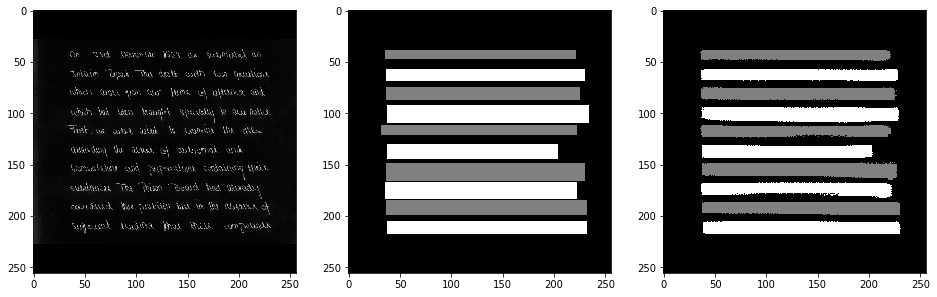

In [30]:
y_pred = model.predict_on_image(dataset.x_test[0])
hplot(dataset.x_test[0], dataset.y_test[0].argmax(axis=-1), y_pred.argmax(axis=-1))

## `Paragraph text recognizer`

In [6]:
from text_recognizer.paragraph_text_recognizer import ParagraphTextRecognizer
import text_recognizer.util as util


K.clear_session()
text_recog = ParagraphTextRecognizer()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256)     0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 256, 256, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 800         reshape[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 16) 12560       conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_2 (

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              (None, 28, 952)      0                                            
__________________________________________________________________________________________________
reshape_1 (Reshape)             (None, 28, 952, 1)   0           image[0][0]                      
__________________________________________________________________________________________________
lambda (Lambda)                 (None, 135, 28, 14,  0           reshape_1[0][0]                  
__________________________________________________________________________________________________
time_distributed (TimeDistribut (None, 135, 128)     510464      lambda[0][0]                     
__________________________________________________________________________________________________
cu_dnnlstm

[(77, 896), (82, 905), (53, 910), (77, 905), (29, 159), (29, 900), (82, 881), (48, 876), (24, 876), (58, 925), (58, 930), (77, 939), (24, 934), (24, 745), (77, 944), (24, 852), (24, 934), (77, 963), (24, 765), (72, 934), (72, 992), (24, 915), (77, 193), (24, 276), (38, 271)]


/home/saurabh/.local/share/virtualenvs/pandagrader-2b4G2K8K/lib/python3.6/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


'iiiiitttff st ttr t t tm fft t tss ii bfis wit t ttfw ta m ff t ls ss o v  f l t t tfr tt tf f ii li ss k ss i lat n z fiii t tiit ti  iii ii tiiiii ii ii e a itt fr wa ttt Ha t ftmtt ff to ttf f rt t wftf tf t ll ll ill ll f tt ft tt t t t tidt hiid iiliii ti bicii f i t t t t tt ty ftf ii i i l i ii i i  i s m t ff tf t t t t t tf t t wi t t w t wiis isiii ta tiii ii  di dittdisd tt ii tii Sll'

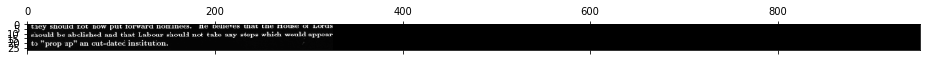

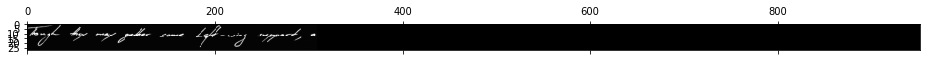

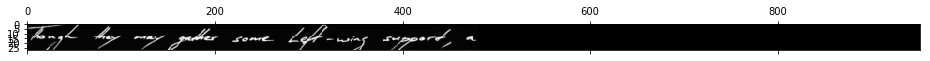

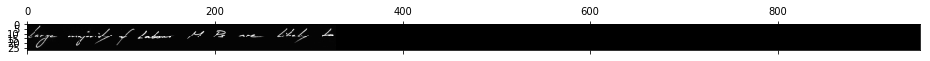

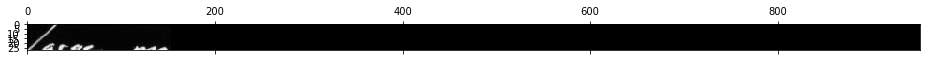

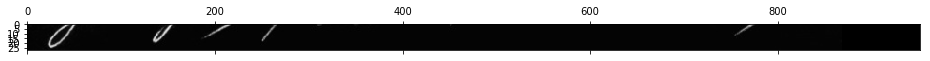

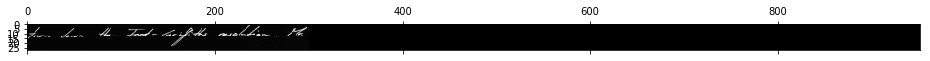

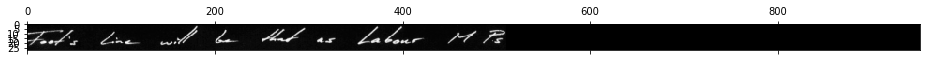

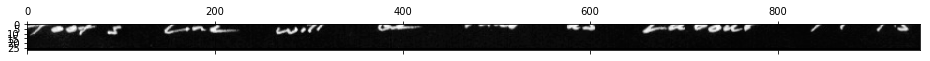

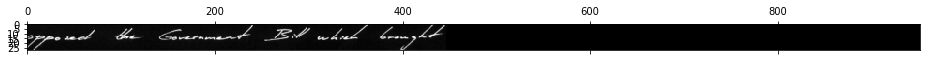

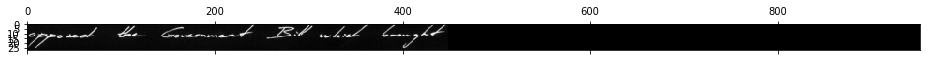

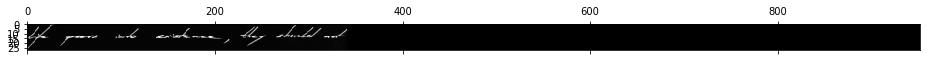

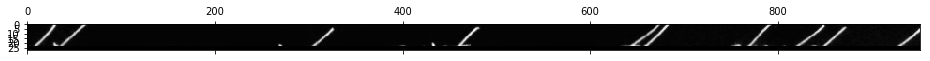

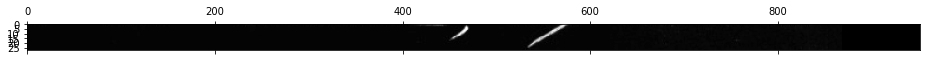

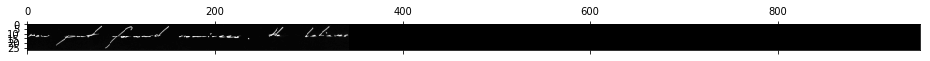

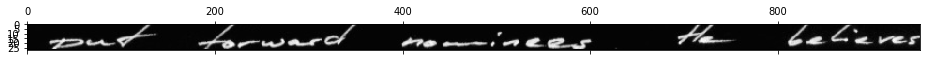

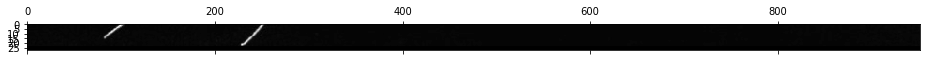

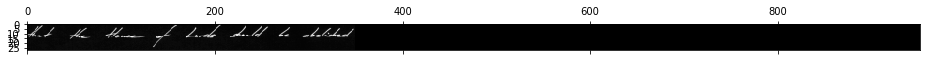

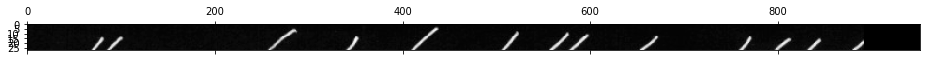

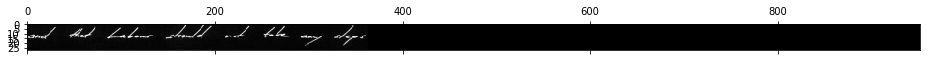

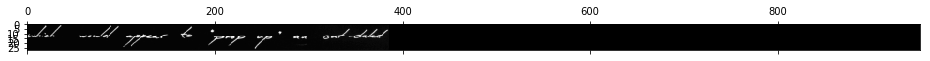

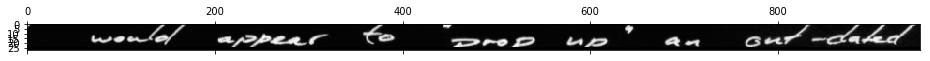

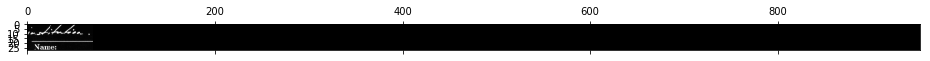

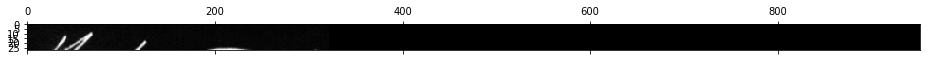

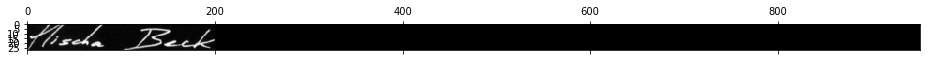

In [28]:
image_basenames = ['a01-000u.jpg', 'a01-000x.jpg', 'a01-003.jpg', 'a01-003u.jpg']

image_or_filename = f'../../data/raw/iam/iamdb/forms/{image_basenames[2]}'
# image_or_filename = '../../data/processed/iam_paragraphs/crops/a01-000u.jpg'

string, crops = text_recog.predict(image_or_filename)
for crop in crops:
    plt.matshow(crop, cmap='gray')
string

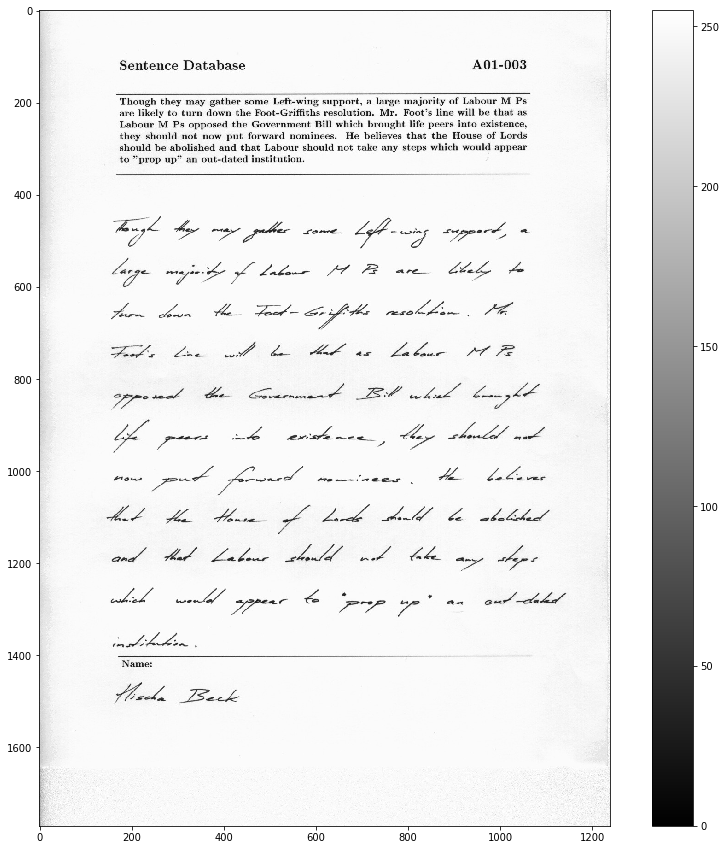

In [29]:
real_image = util.read_image(image_or_filename, grayscale=True)
plot(real_image)

In [30]:
from text_recognizer.paragraph_text_recognizer import _crop_out_square_image

real_image = util.read_image(image_or_filename, grayscale=True)
square_image = _crop_out_square_image(real_image)
image, scale_down_factor = text_recog._prepare_image_for_line_detector_model(square_image)
line_segmentation = text_recog.line_detector_model.predict_on_image(image)

In [31]:
real_image.shape, square_image.shape, image.shape, scale_down_factor, line_segmentation.shape

((1771, 1240), (1240, 1240), (256, 256), 4.84375, (256, 256, 3))

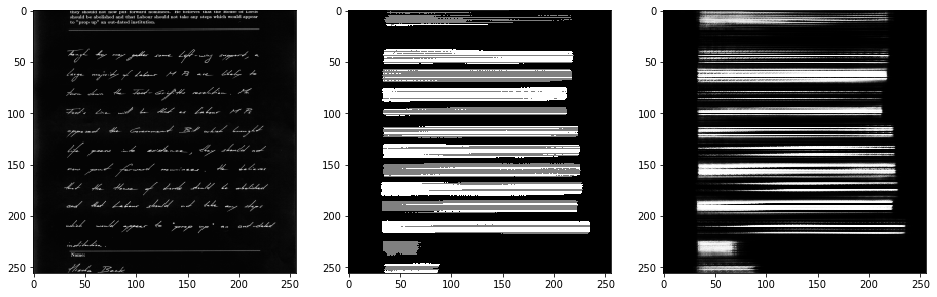

In [33]:
hplot(image, np.argmax(line_segmentation, axis=-1), line_segmentation[:,:,1])

In [ ]:
plot(line_segmentation)